# Mesh loading example


In [172]:
!pip3 install --upgrade pip 
!pip3 install -U "meshio[all]" pyvista ipyvtklink networkx pymetis numpy numba

  Using cached pyvista-0.31.3-py3-none-any.whl (1.3 MB)
     |████████████████████████████████| 2.2 MB 1.8 MB/s 
  Using cached pyvista-0.31.2-py3-none-any.whl (1.3 MB)
  Using cached pyvista-0.31.1-py3-none-any.whl (1.3 MB)
  Using cached pyvista-0.31.0-py3-none-any.whl (1.3 MB)
  Using cached pyvista-0.30.1-py3-none-any.whl (1.2 MB)
  Using cached pyvista-0.30.0-py3-none-any.whl (1.2 MB)
  Using cached pyvista-0.29.1-py3-none-any.whl (1.2 MB)
  Using cached pyvista-0.29.0-py3-none-any.whl (1.2 MB)
  Using cached pyvista-0.28.1-py3-none-any.whl (1.2 MB)
  Using cached pyvista-0.28.0-py3-none-any.whl (1.2 MB)
  Using cached pyvista-0.27.4-py3-none-any.whl (1.2 MB)
  Using cached pyvista-0.27.3-py3-none-any.whl (1.2 MB)
  Using cached pyvista-0.27.2-py3-none-any.whl (1.2 MB)
  Using cached pyvista-0.27.1-py3-none-any.whl (1.2 MB)
  Using cached pyvista-0.27.0-py3-none-any.whl (1.2 MB)
  Using cached pyvista-0.26.1-py3-none-any.whl (1.2 MB)
  Using cached pyvista-0.26.0-py3-none-any.whl 

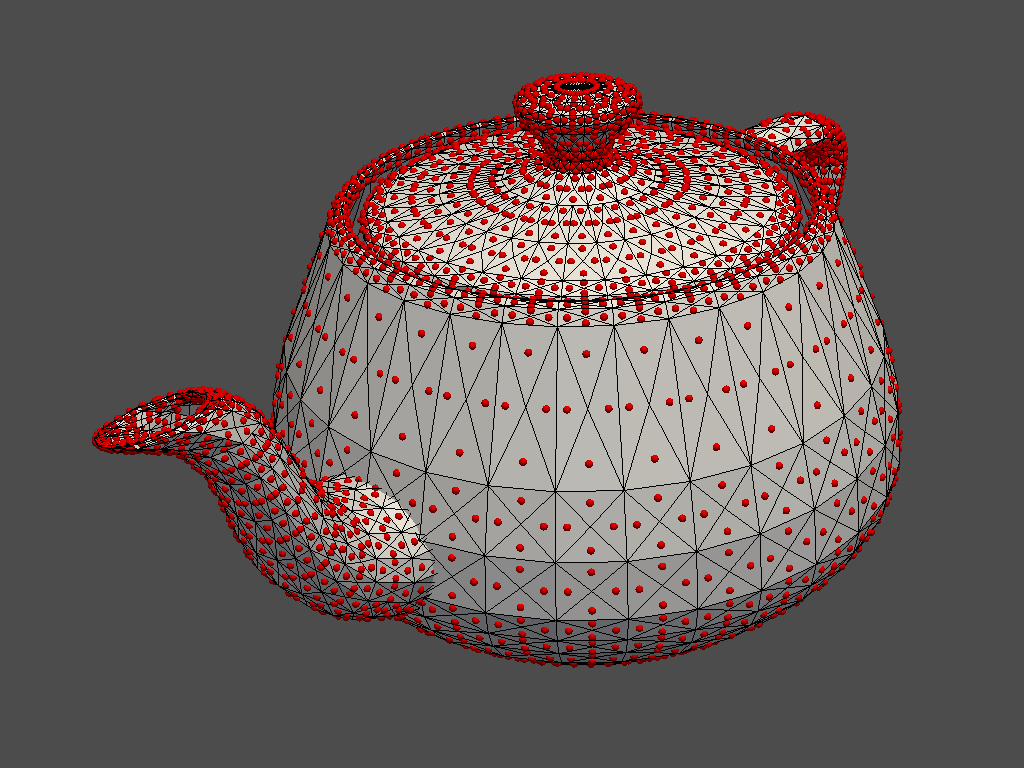

In [4]:
import meshio
import pyvista as pv
from pyvista import examples

# Loading a mesh example
mesh = examples.download_teapot()

cpos = [(6.192871661244108, 5.687542355343226, -4.95345468836544),
 (0.48853358141600634, 1.2019347531215714, 0.1656178278582367),
 (-0.40642070472687936, 0.8621356761976646, 0.30256286387543047)]

centers = mesh.cell_centers()

p = pv.Plotter()
p.add_mesh(mesh, show_edges=True, line_width=1)
p.add_mesh(centers, color="r", point_size=8.0, render_points_as_spheres=True)
p.show(cpos=cpos)

In [25]:
len(mesh.points)

1976

In [26]:
import pymetis
n_cuts, membership = pymetis.part_graph(2, adjacency=adjacency_list)

NameError: name 'adjacency_list' is not defined

In [71]:
X= meshio.read('/Users/work/dev/meshes/ftetwild_output_meshes/ftetwild_output_msh/71046.stl_0121.msh')

In [112]:
X.points.shape

(3822, 3)

In [110]:
len(X.cell_data_Dict['color']['tetra'])

15691

In [152]:
num_cells = [len(y) for y in X.cells_dict.values()][0]
X.cells_Dict['tetra']

array([[1613, 1435, 1519, 1740],
       [ 849,  395, 3397, 2632],
       [ 627, 1223, 1951,  389],
       ...,
       [2831, 2397, 3232, 3544],
       [2765, 2363, 2900, 2635],
       [ 952, 2363, 2900, 2765]], dtype=int32)

# Halo Exchange for Cells

The unstructured mesh is distributed through the memories of several processes (MPI ranks).
Each rank only needs to store the part of the mesh it will be operating on, plus some surrounding cells
required for computation. Neighbouring processes will need to exchange the values of border cells to
keep values up to ate. 

In this section, we look at this process in detail.

We have an unstructured mesh of cells, in which each MPI rank has several neighbour ranks.

Some of the cells are interior to the MPI rank: no other rank will need their values to be able to
calculate the fluid fields. Howeverm some of the cells are "border cells", and neighbouring ranks
need to know the values in these cells for their calculations. In addition, this rank needs to 
know values of the adjacent cells to its border cells, which belong to neighbouring ranks: its stores
these "ghost cells", but never updates their values.

At the end of each timestep calculation, we perform a _halo exchange_ to tell neighbours the new
values of our boundary cells, and to receive new values for our "ghost cells".

Fortunately, after the partitioning is complete, each process knows statically:
* Which are its neighbour ranks
* Which cells are border cells, and which neighbour ranks need their values
* Which cells are ghost cells, and which neighbour ranks to receive the updated values from

Recall that each process stores its cells (whether interior, boundary and ghost cells) in a 
densely packed, contiguous local structure. Each cell has a local id, which identifies the
cell in this structure. However, each cell also has a global id, which is the same accross all ranks.
Consequently, we store maps that allow local processes to look up the global id for a local cell and vice versa.

After partitioning, each process know which global cell ids to send to which neighbour, and which 
global cell ids to receive from each neighbour. We can precompute some structures:

* A receive buffer, which knows how much data we'll be receiving from each neighbour, and which
local cell that represents. This allos us to easily perform an optimised _local scatter_ operation to
redistribute these received values from the receive buffer back to their correct position in the local cells array.
* Since we know which global cell ids we'll be sending to which neighbour, we can build a densely
packed send buffer and perform an optimised _local gather_ operation, which 
collects the values we want to send from their positions in the local cells array and places them
in the densely packed send structure.

![An unstructured mesh distributed over 4 processes](images/halo-exchange.svg "Halo exchange for a distributed mesh")

In [198]:
from mpi4py import MPI
from typing import Iterable, Dict, List
from numpy.typing import NDArray
from minicombust.data_structures import T, LocalId, GlobalId
import numpy as np

comm = MPI.COMM_WORLD
my_rank = comm.Get_rank()
nproc = comm.Get_size()
print('Hello from rank {}'.format(my_rank))

Hello from rank 0


In [201]:
# In lieu of partitioning and a real mesh, we'll use this simple example
# from the image in the docs

# Who each ranks neighbours are
mesh_neighbour_ranks = {
    0:[1],
    1:[0,2],
    2:[1,3],
    3:[2]
}

# How many of a rank's ghost cells are owned by each neighbour 
mesh_neighbour_rank_to_num_ghost_cells = {
    0: {1:2},
    1: {0:2, 2:2},
    2: {1:2, 3:2},
    3: {2:2}
}

# How many of a rank's border cells are held as ghost cells by each neighbour 
mesh_neighbour_rank_to_num_border_cells = {
    0 : {1:2},
    1 : {0:2, 2:2},
    2 : {1:2, 3:2},
    3 : {2:2}
}

# Which global cell ids must be received from which neighbour, for each rank 
mesh_neighbour_rank_to_ghost_global_cell_ids = {
    0: {1: [2,3]},
    1: {0: [0,1], 2: [4,5]},
    2: {1: [2,3], 3: [6,7]},
    3: {2: [4,5]}
}

# Which global cell ids must be sent to which neighbour, for each rank
mesh_neighbour_rank_to_border_global_cell_ids = {
    0: {1: [0,1]},
    1: {0: [2,3], 2: [2,3]},
    2: {1: [4,5], 3: [4,5]},
    3: {2: [6,7]}
}

# map from global cell id for local cell id for each rank (only bother with border cells and ghost cells)
mesh_global_cell_to_local_cell_id = {
    0: {0:0, 1:1, 2:2, 3:3},
    1: {0:0, 1:1, 2:2, 3:3, 4:4, 5:5},
    2: {2:0, 3:1, 4:2, 5:3, 6:4, 7:5},
    3: {4:0, 5:1, 6:2, 7:3}
}

# map from local cell id for global cell id for each rank (only bother with border cells and ghost cells)
mesh_local_cell_to_global_cell_id = {
    0: {0:0, 1:1, 2:2, 3:3},
    1: {0:0, 1:1, 2:2, 3:3, 4:4, 5:5},
    2: {0:2, 1:3, 2:4, 3:5, 4:6, 5:7},
    3: {0:4, 1:5, 2:6, 3:7}
}

In [202]:
# This is all of the mesh that each local process needs to store:
neighbour_ranks: List[int] = mesh_neighbour_ranks[my_rank]
neighbour_rank_to_num_ghost_cells: Dict[int, np.int64] = mesh_neighbour_rank_to_num_ghost_cells[my_rank]
neighbour_rank_to_num_boundary_cells: Dict[int, np.int64] = mesh_neighbour_rank_to_num_border_cells[my_rank]
neighbour_rank_to_boundary_global_cell_ids = mesh_neighbour_rank_to_border_global_cell_ids[my_rank]
neighbour_rank_to_ghost_global_cell_ids = mesh_neighbour_rank_to_ghost_global_cell_ids[my_rank]
global_cell_to_local_cell_id: Dict[GlobalId, LocalId] = mesh_global_cell_to_local_cell_id[my_rank]
local_cell_to_global_cell_id: Dict[LocalId, GlobalId] = mesh_local_cell_to_global_cell_id[my_rank]
neighbour_rank_to_received_cell_values: Dict[int, NDArray] = {i: np.zeros((len(neighbour_rank_to_ghost_global_cell_ids[i])), dtype=T) for i in neighbour_ranks}
cells: NDArray[T] = np.zeros((len(local_cell_to_global_cell_id),), dtype=T)

# Just some dummy values for this example
cells[:] = my_rank

def gather_local_cell_values_for_ids(ids : Iterable[LocalId]) -> NDArray[T]:
    return np.take_along_axis(cells, np.array(list(ids)), axis=None)

def send_to_single_neighbour(dst_rank: int):
    global_cell_ids = neighbour_rank_to_boundary_global_cell_ids[dst_rank]
    local_cell_ids = (global_cell_to_local_cell_id[i] for i in global_cell_ids)
    src_cell_vals = gather_local_cell_values_for_ids(local_cell_ids)
    #print("{} sends border to {}: {}".format(my_rank, dst_rank, len(src_cell_vals)))
    return comm.Isend(src_cell_vals, dest=dst_rank)

def receive_from_single_neighbour(src_rank: int):
    arr = neighbour_rank_to_received_cell_values[src_rank]
    #print("{} receives ghost from {}: {}".format(my_rank, src_rank, len(arr)))
    return comm.Irecv(arr, source=src_rank)

def perform_updates_on_local_cells():
    # Insert fluid solver of your choice here
    pass

def scatter_received_halos_to_cells():
    def scatter_single_rank(rank):       
        global_cell_ids = neighbour_rank_to_ghost_global_cell_ids[rank]
        local_cell_ids = np.array([global_cell_to_local_cell_id[i] for i in global_cell_ids])
        np.put_along_axis(cells, local_cell_ids, neighbour_rank_to_received_cell_values[rank], axis=None)

    for rank in neighbour_ranks:
        scatter_single_rank(rank)


def halo_exchange():
    # We use non-blocking comms for the exchange
    # to avoid deadlock. Dependencies are mesh-dependent
    # and so are difficult to create perfect blocking comms for.
    # But this might be worth optimising more
    reqs = []
    for rank in range(len(neighbour_ranks)):
        reqs.append(receive_from_single_neighbour(neighbour_ranks[rank]))
        reqs.append(send_to_single_neighbour(neighbour_ranks[rank]))
    MPI.Request.Waitall(reqs)
    scatter_received_halos_to_cells()

def main_loop():
    halo_exchange()
    for timestep, idx in enumerate(range(10)):
        perform_updates_on_local_cells()
        halo_exchange()
        if my_rank == 0:
            print("Timestep {} complete".format(idx))

def main():
    main_loop()

if __name__ == "__main__":
    main()

Exception: MPI_ERR_RANK: invalid rank